## Analyzing Raw Data

In [1]:
## Import data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import sklearn

PRESSURE_PATH = '/Users/jiujiu/Desktop/496_New_Data/pressure/'   # pressure data
SATURATION_PATH = '/Users/jiujiu/Desktop/496_New_Data/saturation/' # saturation data
PRODUCTION_PATH = '/Users/jiujiu/Desktop/496_New_Data/production/' # production data

def pullseries(PATH, NAME, index_list):
    # input: NAME - 'saturation' or 'pressure'
    data = []
    for i in index_list:
        temp_data = np.loadtxt(PATH+NAME+str(i)+'.txt',delimiter = ',')
        #temp_data = np.reshape(temp_data,(75,60,220),order ='F')
        data.append(temp_data)
    data = np.float32(data)
    # restructure data into long array (total snapshots , 13200)
    # total snapshots = n X 75
    # 13200 = total grid points = 60 X 220
    data = data.reshape((data.shape[0]*data.shape[1],data.shape[2])) 
    return data

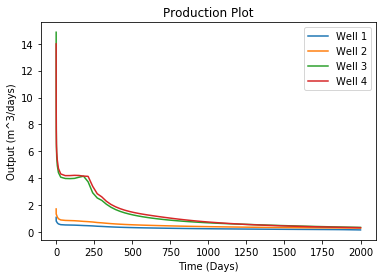

In [2]:
# check production data
Prod_unsized = np.loadtxt(PRODUCTION_PATH + '/production2.txt')
Prod_resized = np.array([Prod_unsized[:,0]/3600.0/24.0, 
                         Prod_unsized[:,1]*3600*24,
                         Prod_unsized[:,2]*3600*24,
                         Prod_unsized[:,3]*3600*24,
                         Prod_unsized[:,4]*3600*24])
well_1 = plt.plot(Prod_resized[0,],Prod_resized[1,],label='Well 1')
well_2 = plt.plot(Prod_resized[0,],Prod_resized[2,],label='Well 2')
well_3 = plt.plot(Prod_resized[0,],Prod_resized[3,],label='Well 3')
well_4 = plt.plot(Prod_resized[0,],Prod_resized[4,],label='Well 4')
plt.title('Production Plot')
# plt.yscale('log')
plt.xlabel('Time (Days)')
plt.ylabel('Output (m^3/days)')
plt.legend()
plt.savefig('Production Plot2.png')

## Autoencoders

In [216]:
%matplotlib notebook
# pull saturation data, 30 examples total
STRAIN = pullseries(SATURATION_PATH, 'saturaton', np.arange(1,81))
STEST = pullseries(SATURATION_PATH, 'saturaton', np.arange(81,101))
# PTRAIN = pullseries(PRESSURE_PATH, 'pressure', np.arange(1,3))

# Strain, Sscaler = scale_data(STRAIN)
# Stest = Sscaler.transform(STEST)
Strain = STRAIN
Stest = STEST
Strain_reshaped = np.reshape(Strain,(len(Strain), 60, 220, 1),order= 'F')
Stest_reshaped = np.reshape(Stest,(len(Stest), 60, 220, 1),order= 'F')
print(Strain_reshaped.dtype)

float32


In [110]:
print(Strain_reshaped.shape)
print(Stest_reshaped.shape)
# fig = plt.figure()
# ax1 = fig.add_subplot(111)
# plt.ion()
# fig.show()
# ax1.imshow(Strain_reshaped[72,:,:,0])

(1875, 60, 220, 1)
(375, 60, 220, 1)


In [84]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(60, 220, 1))  # y, x

x = Conv2D(4, (6, 22), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# encoded space (8,28,8)
x = Conv2D(1, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(2, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(4, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (6, 22), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

autoencoder.summary()

encoder = Model(input_img, encoded)
# encoder.summary()

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(8,28,1))
deco = autoencoder.layers[-7](encoded_input)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
# decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, 60, 220, 1)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 60, 220, 4)        532       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 30, 110, 4)        0         
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 30, 110, 2)        74        
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 15, 55, 2)         0         
_________________________________________________________________
conv2d_38 (Conv2D)           (None, 15, 55, 1)         19        
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 8, 28, 1)          0         
__________

In [85]:
from keras.callbacks import TensorBoard
# del autoencoder
autoencoder.fit(Strain_reshaped, Strain_reshaped,
                epochs=5,
                batch_size=50,
                shuffle=True,
                validation_data=(Stest_reshaped[0:200,], Stest_reshaped[0:200,]),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])
autoencoder.save('partly_trained_autoencoder.h5')

Train on 1875 samples, validate on 200 samples
Epoch 1/5
1875/1875 [==============================] - 175s 93ms/step - loss: 0.6505 - val_loss: 0.6267
Epoch 2/5
1875/1875 [==============================] - 155s 83ms/step - loss: 0.6225 - val_loss: 0.6253
Epoch 3/5
1875/1875 [==============================] - 155s 83ms/step - loss: 0.6142 - val_loss: 0.6025
Epoch 4/5
1875/1875 [==============================] - 171s 91ms/step - loss: 0.5881 - val_loss: 0.5850
Epoch 5/5
1875/1875 [==============================] - 202s 108ms/step - loss: 0.5824 - val_loss: 0.5839


In [81]:
from keras.models import load_model
#Save partly trained model
autoencoder.save('partly_trained_autoencoder.h5')
del autoencoder

#Reload model
autoencoder = load_model('partly_trained_autoencoder.h5')
autoencoder.fit(Strain_reshaped, Strain_reshaped,
                epochs=10,
                batch_size=25,
                shuffle=True,
                validation_data=(Stest_reshaped[0:150,], Stest_reshaped[0:150,]),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Train on 1875 samples, validate on 150 samples
Epoch 1/10
1875/1875 [==============================] - 302s 161ms/step - loss: 0.0242 - val_loss: 0.0255
Epoch 2/10
1875/1875 [==============================] - 310s 165ms/step - loss: 0.0236 - val_loss: 0.0251
Epoch 3/10
1875/1875 [==============================] - 318s 170ms/step - loss: 0.0232 - val_loss: 0.0247
Epoch 4/10
1875/1875 [==============================] - 327s 174ms/step - loss: 0.0230 - val_loss: 0.0247
Epoch 5/10
1875/1875 [==============================] - 342s 182ms/step - loss: 0.0230 - val_loss: 0.0244
Epoch 6/10
1875/1875 [==============================] - 319s 170ms/step - loss: 0.0230 - val_loss: 0.0249
Epoch 7/10
1875/1875 [==============================] - 322s 172ms/step - loss: 0.0228 - val_loss: 0.0252
Epoch 8/10
1875/1875 [==============================] - 319s 170ms/step - loss: 0.0229 - val_loss: 0.0246
Epoch 9/10
1875/1875 [==============================] - 318s 169ms/step - loss: 0.0228 - val_loss: 0.0260

<IPython.core.display.Javascript object>


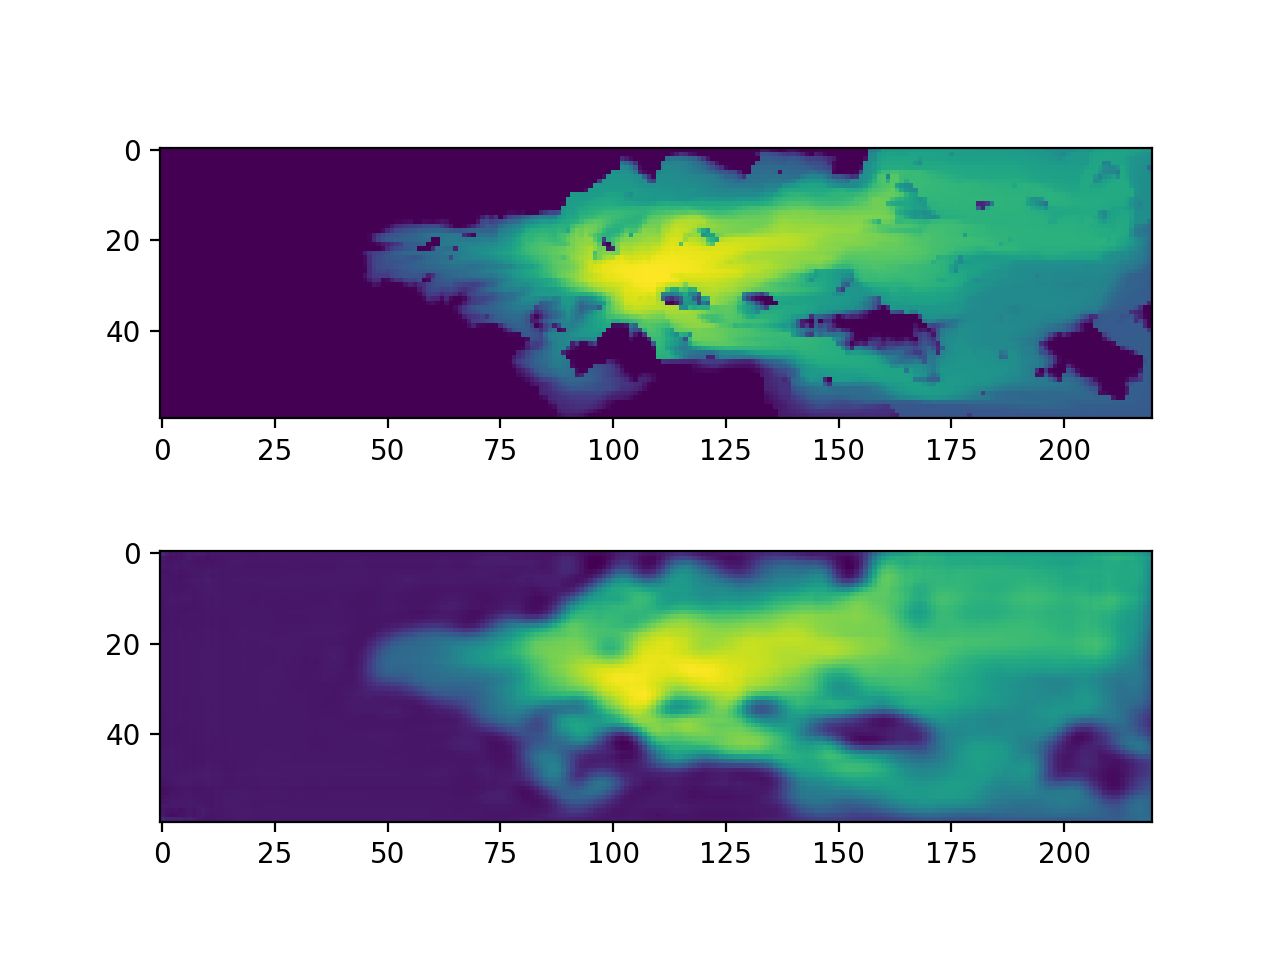

In [205]:
# check AWS trained model
from keras.models import load_model
# del autoencoder
# autoencoder = load_model('trained_autoencoder.h5')
# visualizing model accuracy
interval = np.arange(0,150)
decoded_Saturation = autoencoder.predict(Stest_reshaped[interval,])
animate_compare(Stest_reshaped[interval,],decoded_Saturation[:,])

## Scale data and split into sequences for RNN

In [56]:
from sklearn.preprocessing import MinMaxScaler

def create_dataset(DATA,window_len):
    """
    Takes in a timeseries X to create a dataset such that
    
    X_new = [[X_0,X_1,X_2,...,X_window_len],....[X_end-window_len,....,X_end]]
    Y_new = [X_window_len,....X_end]
    """
    X_new = []
    y_new = DATA[window_len:]
    for index in range(len(DATA) - window_len):        
        temp = [DATA[index]]
        for i in range(1,window_len):
            temp.append(DATA[index+i])
        temp = np.stack(temp)
        X_new.append(temp)
    X_new = np.stack(X_new)
    y_new = np.stack(y_new)
    return X_new,y_new

# def scale_data(X):
#     # input original dataset samples X (x*y)
#     # return normalized data and the corresponding scaler
#     scaler = MinMaxScaler()
#     scaler = scaler.fit(X)
#     print('Min:', scaler.data_min_[0:3], '\nMax: ',scaler.data_max_[0:3])
#     normalized = scaler.transform(X)
#     return normalized, scaler

def prepare_RNN_data(Encoded_data,lookback):
    # assume input is encoded and outputs the tuple containing X and Y for training/ testing
    Out_X = []
    Out_y = []
    for i in range(int(len(Encoded_data)/75)):
        X_temp, y_temp = create_dataset(Encoded_data[i*75:(i+1)*75,:],lookback)
        Out_X.append(X_temp)
        Out_y.append(y_temp)
    Out_X = np.concatenate(Out_X,axis = 0)
    Out_y = np.concatenate(Out_y,axis = 0)
    return (Out_X, Out_y)


## LSTM-RNN

In [239]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
def trainRNN(lookback,TRAIN,TEST,LSTM_unit,episodes):
    # specify Neural Network architecture
    #     Dense1_unit = 100
    #     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    input_dims = X_train.shape[1:] # size of input
    output_dims = y_train.shape[1:]
    dim_prod = int(np.prod(X_train.shape[2:]))
    if lookback == 1:
        # change expected output shape if lookback is 1
        X_train = np.expand_dims(X_train,axis = 1)
        y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    RNN = Sequential()
    RNN.add(Reshape((lookback, dim_prod), input_shape=(input_dims)))
    RNN.add(LSTM(50, activation='relu', input_shape=(lookback,dim_prod)))
    RNN.add(Dense((dim_prod), activation = 'sigmoid'))
    RNN.add(Reshape((output_dims), input_shape=([dim_prod])))
    RNN.compile(loss='binary_crossentropy', optimizer='adam')
    history = RNN.fit(X_train, y_train, epochs=episodes, batch_size=75-lookback, validation_data=(X_test, y_test), verbose=1, shuffle=False)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy')
    plt.legend()
    plt.show()
    RNN.summary()
    return RNN

In [238]:
# benchmark training of Feed-foward Neural Network
def trainFFN(lookback,TRAIN,TEST,Dense_unit,episodes):
    # specify Neural Network architecture
    #     Dense1_unit = 100
    #     LSTM_unit = 30
    # unpack inputs
    X_train, y_train = TRAIN
    X_test, y_test = TEST
    input_dims = X_train.shape[1:] # size of input
    output_dims = y_train.shape[1:]
    dim_prod = int(np.prod(X_train.shape[2:]))
    if lookback == 1:
        # change expected output shape if lookback is 1
        X_train = np.expand_dims(X_train,axis = 1)
        y_test = np.expand_dims(X_test,axis = 1)
    # build neural net
    FFN = Sequential()
    FFN.add(Reshape(([lookback*dim_prod]), input_shape=(input_dims)))
    FFN.add(Dense((Dense_unit), activation = 'sigmoid'))
    FFN.add(Dense((dim_prod), activation = 'sigmoid'))
    print(output_dims)
    FFN.add(Reshape((output_dims), input_shape=([dim_prod])))
    FFN.compile(loss='binary_crossentropy', optimizer='adam')
    history = FFN.fit(X_train, y_train, epochs=episodes, batch_size=75-lookback, validation_data=(X_test, y_test), verbose=1, shuffle=True)
    # plot history
    plt.figure()
    plt.semilogy(np.array(history.history['loss']), label='Training Error')
    plt.semilogy(np.array(history.history['val_loss']), label='Test Error')
    plt.xlabel('Epoch')
    plt.ylabel('Binary CrossEntropy')
    plt.legend()
    plt.show()
    FFN.summary()
    return FFN



## Sequential Test Functions

In [195]:
from numpy import linalg as LA
def updateX(model,X_current,lookback):
    # take in the current X sample and update it using LSTM trained neural net
    # originally [X1 X2 .. X_lookback] -> [X2 .. X_lookback+1]
#     print('X_now:',X_current.shape)
    X_c_train = np.expand_dims(X_current, axis=0)
    x_plusone = model.predict(X_c_train,batch_size=None, verbose=0, steps=None)
    if lookback == 1:
        X_next = x_plusone
    else:
#         print(X_current[1:,].shape,x_plusone.shape)
        X_next = np.vstack((X_current[1:,],x_plusone))
#         print('X_next:',X_next.shape)
    return X_next,x_plusone

def cumulative_test(X_test, y_test, original_y, lookback, RNN_model, decoder):
    # perform cumulative testing
    # X_test should only have length of 75
    # X_test and y_test are in encoded space for RNN to work
    # error analysis and comparison will be done in the original space however
    m = y_test.shape[0]    # total number of samples to loop through
    if m>75-lookback:
        print('ERROR: X_test should have length of 75-lookback')
        return 0
    X_current = X_test[0,] # both X_test should be the same
    i = 0
    errors = np.zeros(m)
    predicted_y = np.zeros(original_y.shape)
    while i < m:
        X_next,y_predicted = updateX(RNN_model,X_current,lookback)
        
        # update X and error term
        X_current = X_next
        y_predicted_original = decoder.predict(y_predicted)
        errors[i] = LA.norm(original_y[i,]-y_predicted_original)/LA.norm(original_y[i,])
        predicted_y[i,:] = y_predicted_original
        i += 1
    return errors, predicted_y

In [52]:
# function to compare resulting sequential states
def animate_compare(y1,y2):
    fig = plt.figure()
    ax1 = fig.add_subplot(211)
    ax2 = fig.add_subplot(212)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(y1)):    
        ax1.clear()
        ax1.imshow(np.reshape(y1[i,:],(60,220),order ='F'))
        ax2.clear()
        ax2.imshow(np.reshape(y2[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)
# plt.title('Water Saturation')
# plt.savefig('Saturation Plot X_1.png')

def animate_single(X):
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    plt.ion()
    fig.show()
    fig.canvas.draw()
    for i in range(len(X)):    
        ax1.clear()
        ax1.imshow(np.reshape(X[i,:],(60,220),order ='F'))
        fig.canvas.draw()
        plt.pause(0.05)

In [175]:
# retreiving encoder and decoder from autoencoder
from keras.models import load_model
del autoencoder
autoencoder = load_model('trained_autoencoder.h5')
#autoencoder = load_model('trained_autoencoder.h5')
encoded_input = Input(shape=(8,28,8))
deco = autoencoder.layers[-7](encoded_input)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
# decoder.summary()
decoder.summary()

input_img = Input(shape=(60, 220, 1))
enco = autoencoder.layers[1](input_img)
enco = autoencoder.layers[2](enco)
enco = autoencoder.layers[3](enco)
enco = autoencoder.layers[4](enco)
enco = autoencoder.layers[5](enco)
enco = autoencoder.layers[6](enco)
encoder = Model(input_img, enco)
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        (None, 8, 28, 8)          0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 28, 8)          584       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 16, 56, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 56, 8)         584       
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 32, 112, 8)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 110, 16)       1168      
_________________________________________________________________
up_sampling2d_3 (UpSampling2 (None, 60, 220, 16)       0         
__________

In [151]:
# code for reshaping the encoded space, not needed
# multiplier = 1
# original_shape = []
# Strain_encoded = encoder.predict(Strain_reshaped)

# # stretch encoded space into vector
# for i in range(1,len(Strain_encoded.shape)):
#     multiplier *= Strain_encoded.shape[i]
#     original_shape.append(Strain_encoded.shape[i])
# Strain_encoded = np.reshape(Strain_encoded, (Strain_encoded.shape[0],int(multiplier)))
# Stest_encoded = np.reshape(Stest_encoded, (Stest_encoded.shape[0],int(multiplier)))


# # reshape strectched encoded vector back to original shape for decoding
# Strain_encoded = np.reshape(Strain_encoded, tuple([Strain_encoded.shape[0]]+original_shape))
# Strain_encoded = np.reshape(Stest_encoded, tuple([Stest_encoded.shape[0]]+original_shape))
# print(Strain_encoded.shape)
# Strain_decoded = decoder.predict(Strain_encoded[0:10])
# plt.figure()
# plt.imshow(Strain_decoded[1,:,:,0])

In [230]:
# testing architecture for Feed-forward Net
FFN = Sequential()
FFN.add(Dense(100, input_shape=(1,3,1792)))
FFN.add(Dense((1792)))
FFN.compile(loss='mean_squared_error', optimizer='adam')
FFN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_45 (Dense)             (None, 1, 3, 100)         179300    
_________________________________________________________________
dense_46 (Dense)             (None, 1, 3, 1792)        180992    
Total params: 360,292
Trainable params: 360,292
Non-trainable params: 0
_________________________________________________________________


In [208]:
# testing architecture for RNN
time_steps = 11
RNN = Sequential()
RNN.add(Reshape((time_steps, 1792), input_shape=(time_steps,8,28,8)))
RNN.add(LSTM(50, activation='relu', input_shape=(time_steps,1792)))
RNN.add(Dense((1792), activation = 'sigmoid'))
RNN.add(Reshape((8, 28, 8), input_shape=(1,1792)))
RNN.compile(loss='binary_crossentropy', optimizer='adam')
RNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_16 (Reshape)         (None, 11, 1792)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 50)                368600    
_________________________________________________________________
dense_36 (Dense)             (None, 1792)              91392     
_________________________________________________________________
reshape_17 (Reshape)         (None, 8, 28, 8)          0         
Total params: 459,992
Trainable params: 459,992
Non-trainable params: 0
_________________________________________________________________


## Saturation Test

Train on 5200 samples, validate on 1300 samples
Epoch 1/20
5200/5200 [==============================] - 17s 3ms/step - loss: 0.4206 - val_loss: 0.3812
Epoch 2/20
5200/5200 [==============================] - 10s 2ms/step - loss: 0.3817 - val_loss: 0.3811
Epoch 3/20
5200/5200 [==============================] - 10s 2ms/step - loss: 0.3815 - val_loss: 0.3809
Epoch 4/20
5200/5200 [==============================] - 10s 2ms/step - loss: 0.3811 - val_loss: 0.3804
Epoch 5/20
5200/5200 [==============================] - 10s 2ms/step - loss: 0.3802 - val_loss: 0.3794
Epoch 6/20
5200/5200 [==============================] - 10s 2ms/step - loss: 0.3795 - val_loss: 0.3788
Epoch 7/20
5200/5200 [==============================] - 11s 2ms/step - loss: 0.3789 - val_loss: 0.3785
Epoch 8/20
5200/5200 [==============================] - 11s 2ms/step - loss: 0.3786 - val_loss: 0.3784
Epoch 9/20
5200/5200 [==============================] - 10s 2ms/step - loss: 0.3782 - val_loss: 0.3782
Epoch 10/20
5200/5200 [==

<IPython.core.display.Javascript object>


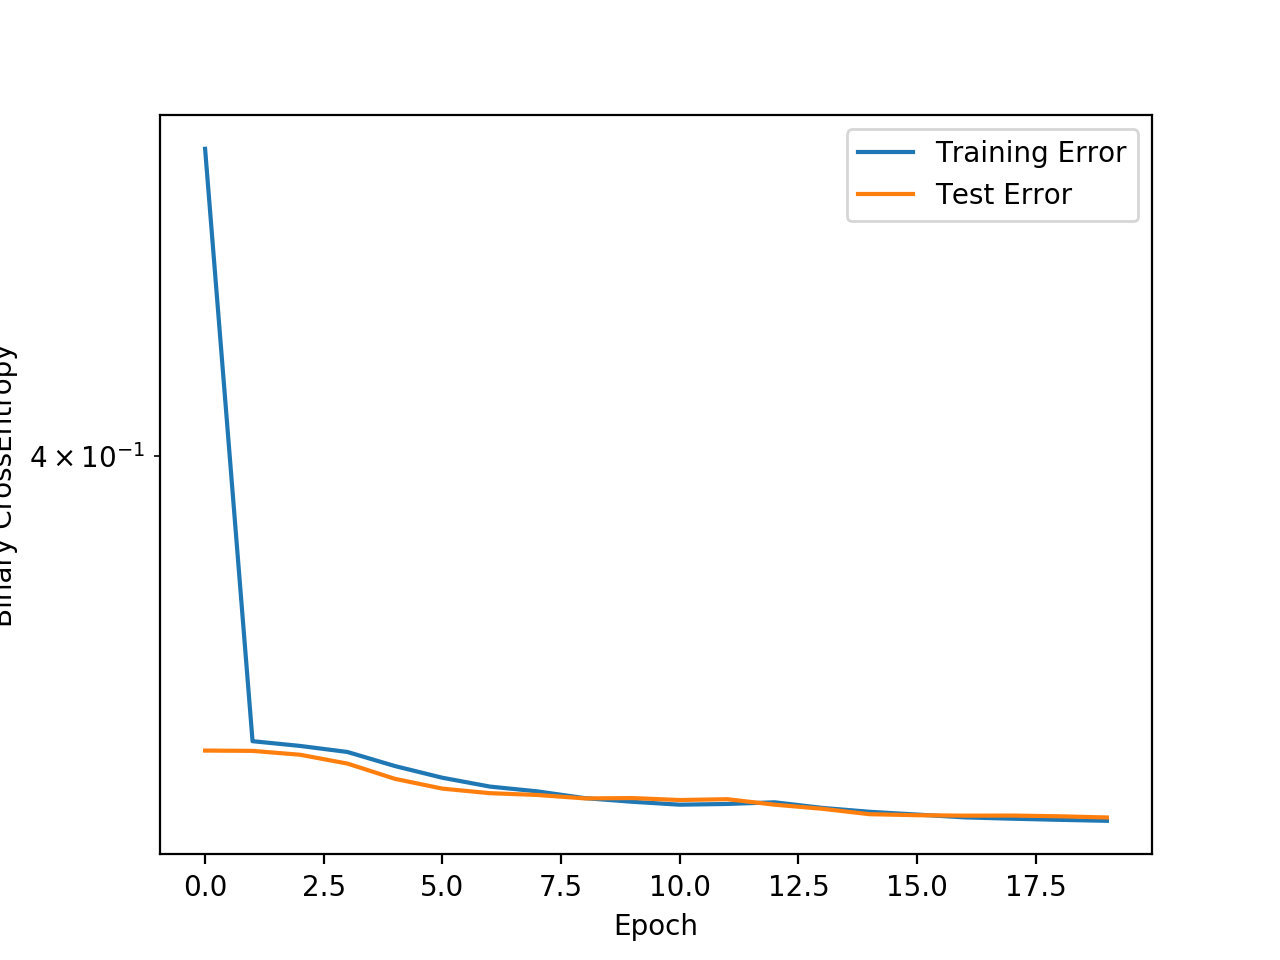

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_33 (Reshape)         (None, 10, 1792)          0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 50)                368600    
_________________________________________________________________
dense_53 (Dense)             (None, 1792)              91392     
_________________________________________________________________
reshape_34 (Reshape)         (None, 8, 28, 8)          0         
Total params: 459,992
Trainable params: 459,992
Non-trainable params: 0
_________________________________________________________________


In [242]:
%matplotlib notebook

# encode training and testing data
Strain_encoded = encoder.predict(Strain_reshaped)
Stest_encoded = encoder.predict(Stest_reshaped)
# transform encoded data into trainable sets
lookback = 10
STRAIN = prepare_RNN_data(Strain_encoded,lookback)
STEST = prepare_RNN_data(Stest_encoded,lookback)
# train model using training and testing sets
RNN_model = trainRNN(lookback,STRAIN,STEST,50,20)

(8, 28, 8)
Train on 5200 samples, validate on 1300 samples
Epoch 1/20
5200/5200 [==============================] - 12s 2ms/step - loss: 0.4451 - val_loss: 0.3825
Epoch 2/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3815 - val_loss: 0.3809
Epoch 3/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3810 - val_loss: 0.3808
Epoch 4/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3809 - val_loss: 0.3807
Epoch 5/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3808 - val_loss: 0.3807
Epoch 6/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3808 - val_loss: 0.3807
Epoch 7/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3808 - val_loss: 0.3807
Epoch 8/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3808 - val_loss: 0.3807
Epoch 9/20
5200/5200 [==============================] - 7s 1ms/step - loss: 0.3808 - val_loss: 0.3807
Epoch 10/20
5200/5200 

<IPython.core.display.Javascript object>


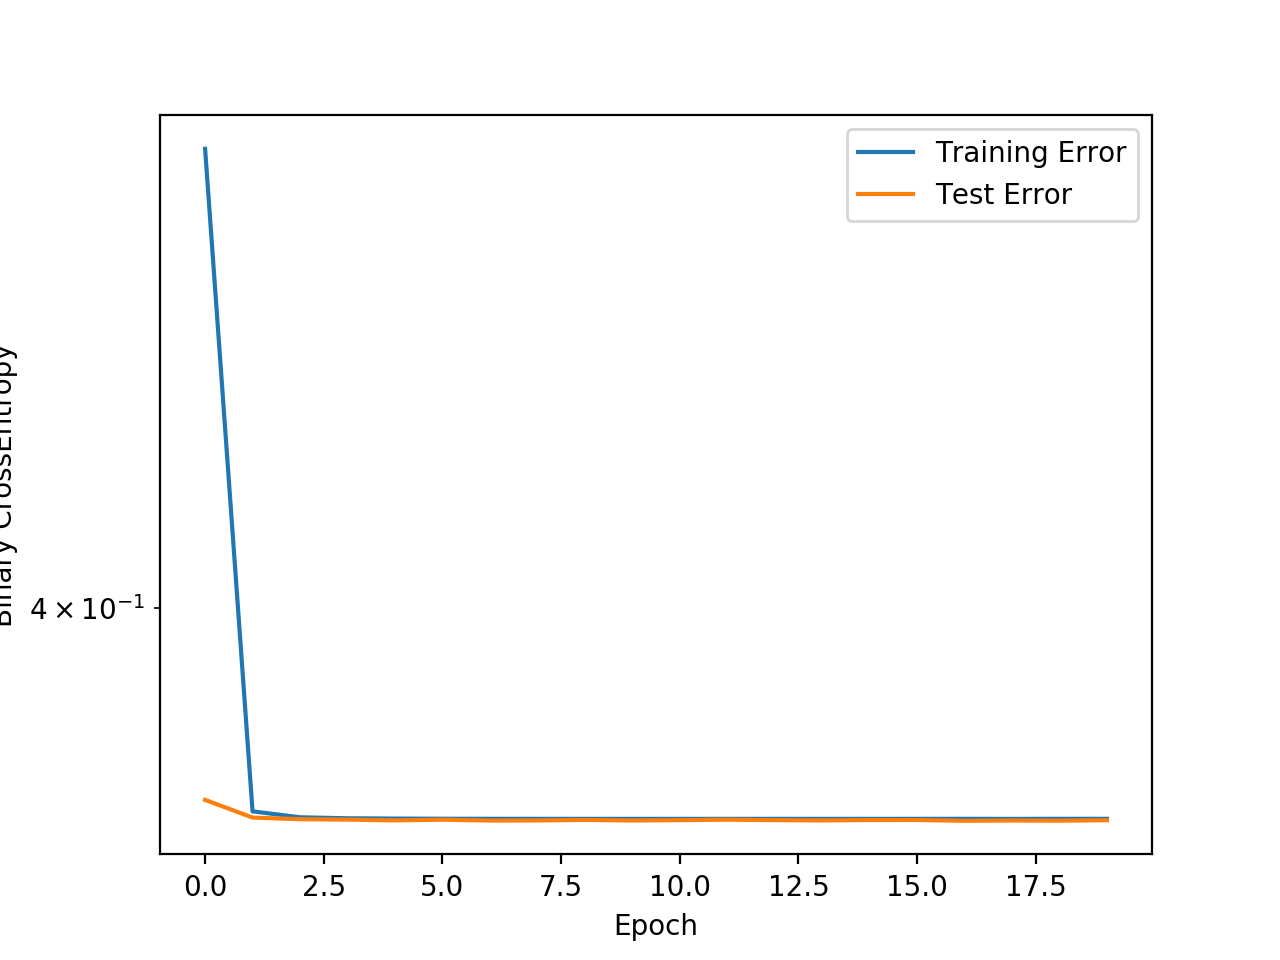

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_35 (Reshape)         (None, 17920)             0         
_________________________________________________________________
dense_54 (Dense)             (None, 50)                896050    
_________________________________________________________________
dense_55 (Dense)             (None, 1792)              91392     
_________________________________________________________________
reshape_36 (Reshape)         (None, 8, 28, 8)          0         
Total params: 987,442
Trainable params: 987,442
Non-trainable params: 0
_________________________________________________________________


In [243]:
FFN_model = trainFFN(lookback,STRAIN,STEST,50,20)

In [ ]:
# prepare for analysis, generate data for comparison
Incre = 75-lookback
X,y = STEST
print(X.shape,y.shape)
decoded_y = decoder.predict(y)
# rearrange original [n,60,220,1] dataset into trucated dataset
original_X, original_y = prepare_RNN_data(Stest_reshaped,lookback) 
print(original_y.shape)

<IPython.core.display.Javascript object>


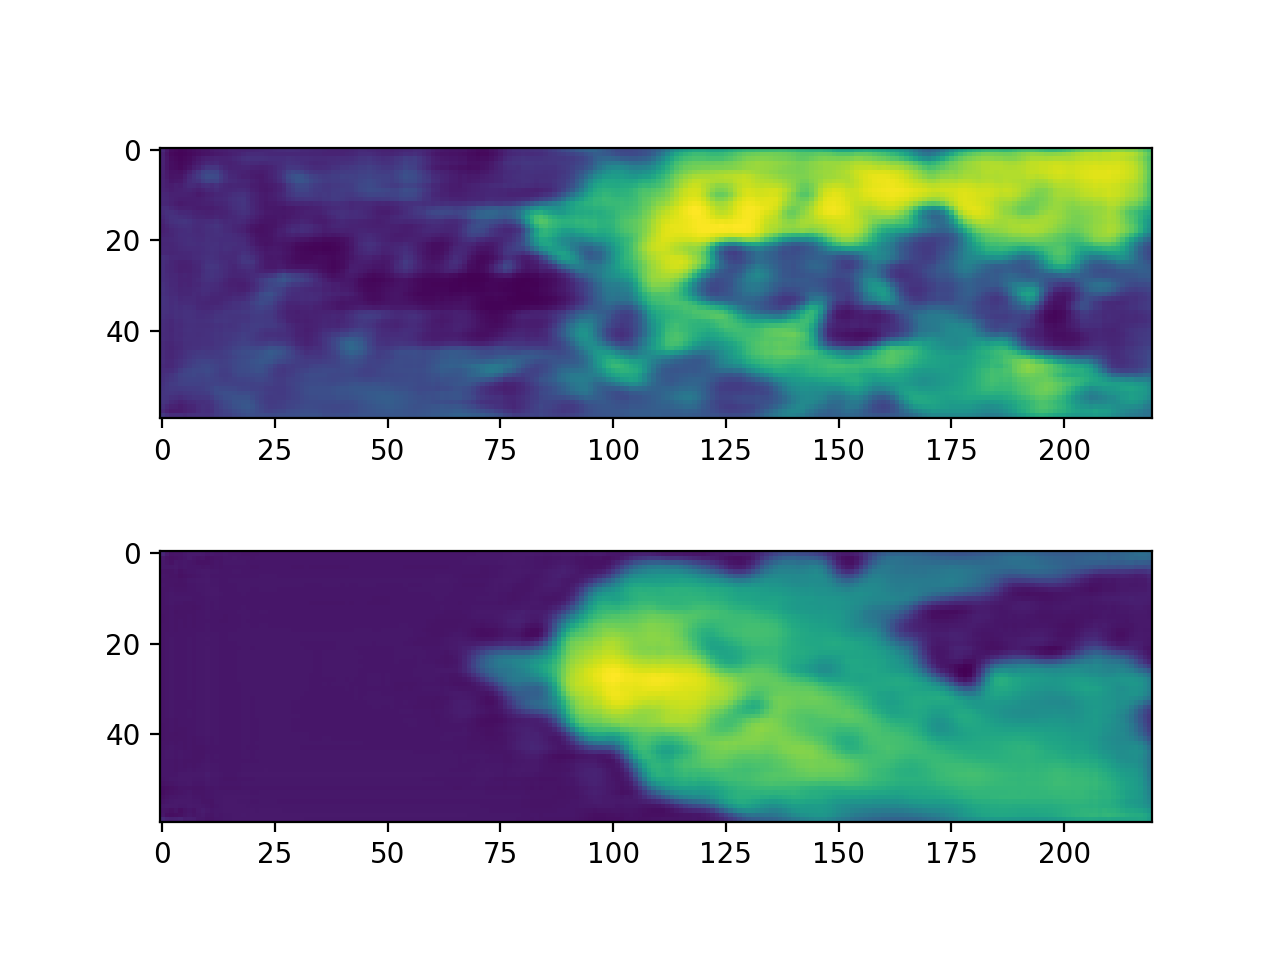

<IPython.core.display.Javascript object>


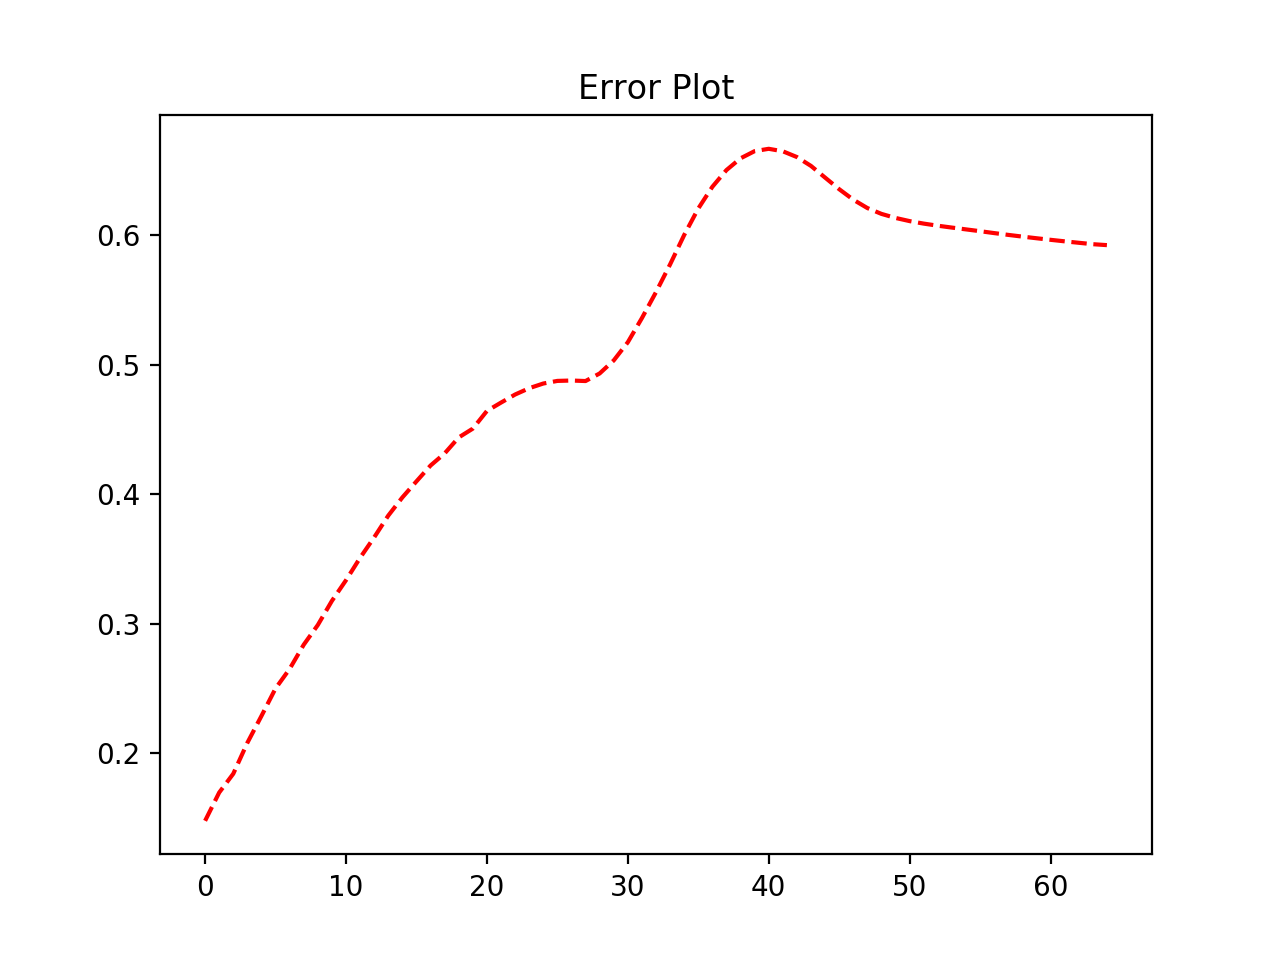

In [245]:
Interval = np.arange(Incre*2,Incre*3) # interval for testing sequentially
# switch out between decoded_y and original_y for different comparisons
errors, predicted_y = cumulative_test(X[Interval,], y[Interval,], decoded_y[Interval,], lookback, RNN_model, decoder)
animate_compare(predicted_y,decoded_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

<IPython.core.display.Javascript object>


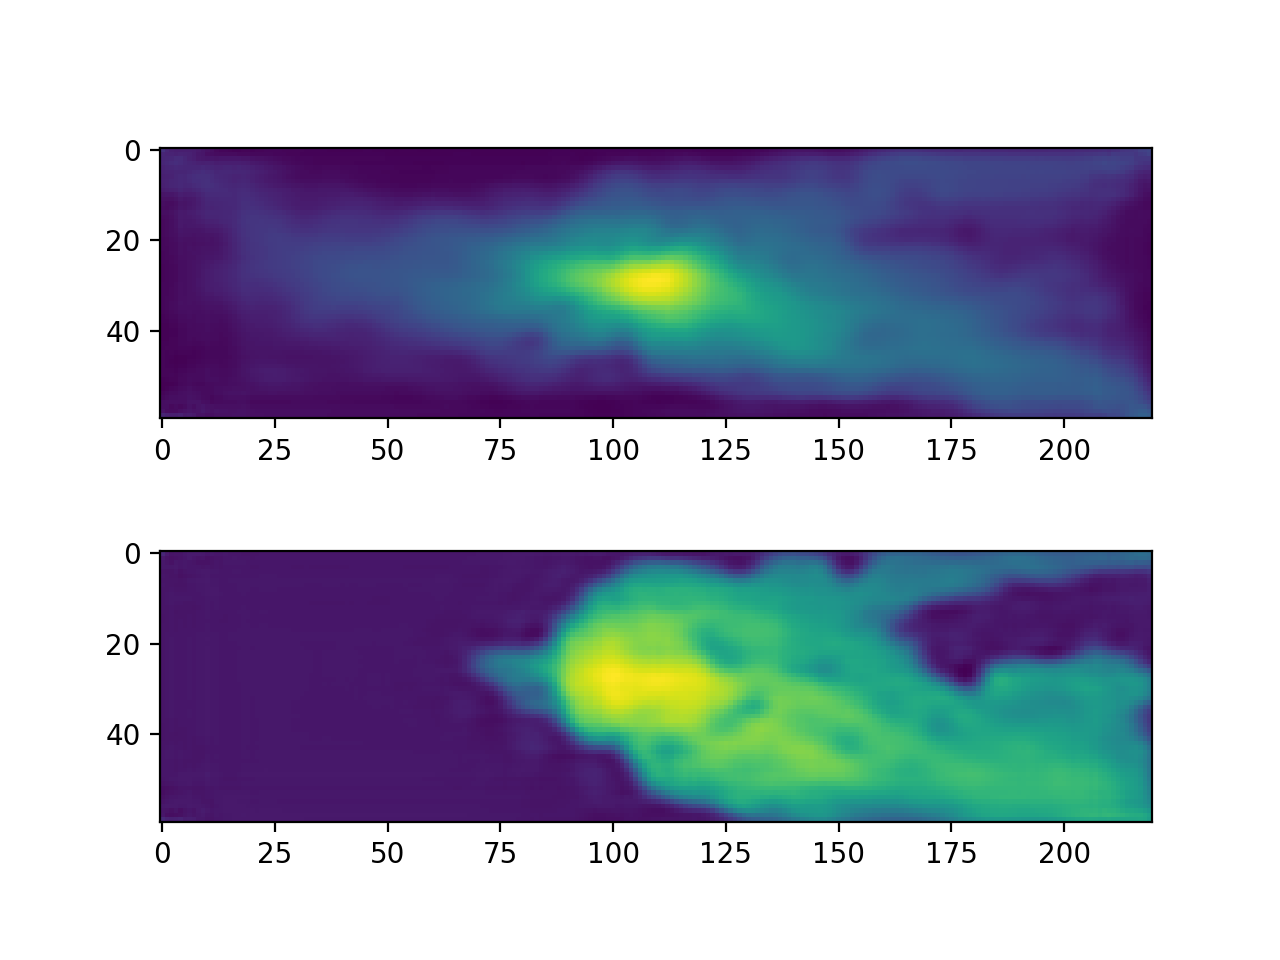

<IPython.core.display.Javascript object>


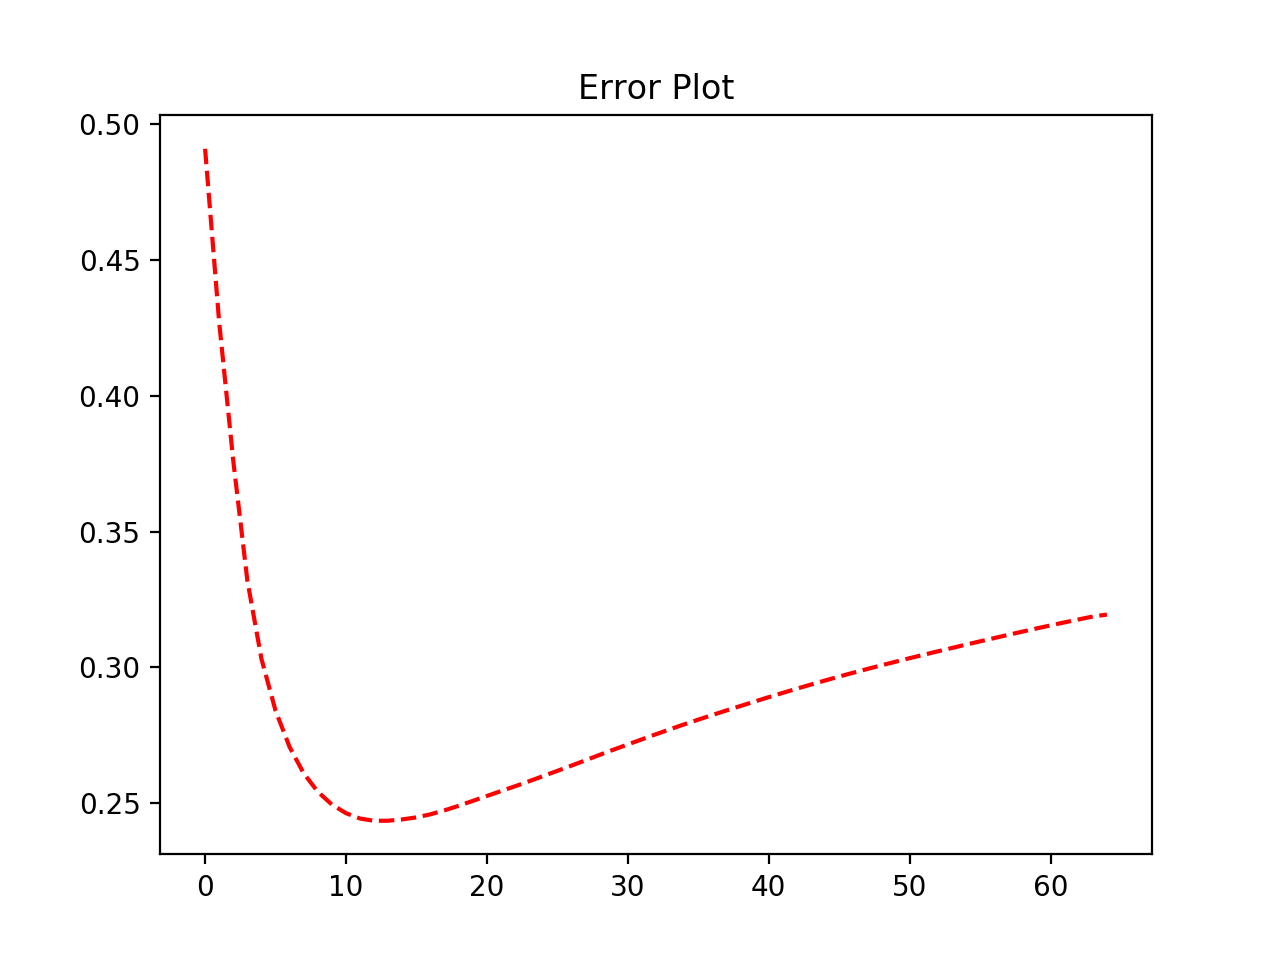

In [246]:
errors, predicted_y = cumulative_test(X[Interval,], y[Interval,], decoded_y[Interval,], lookback, FFN_model, decoder)
animate_compare(predicted_y, decoded_y[Interval,])
plt.figure()
plt.title('Error Plot')
plt.plot(np.arange(len(errors)), errors, 'r--')

## Pressure Test